In [1]:
import os,sys
import cPickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from time import time

sys.path.insert(0,'lib/')
import config
import diagnostics
import base_model

from sklearn.metrics import average_precision_score

import tensorflow as tf

%matplotlib inline

In [2]:
with open(config.labels_path) as f:
    labels = pickle.load(f)

In [3]:
class Spectrograms(base_model.Model):
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512              # lvl1 nodes
        self.d = 4096              # lvl1 receptive field
        
        self.k2 = 512              # lvl2 nodes

        # number of lvl1 features
        regions = 1 + (self.window - self.d)/self.stride
        print 'Number of V1 feature regions: {}'.format(regions)

        wscale = 10e-3
        with tf.variable_scope('parameters'):
            w = tf.Variable(wscale*tf.random_normal([1,self.d,1,self.k],seed=999))
            wavg = self.register_weights(w,'w',average=.9998)
            w1 = tf.Variable(wscale*tf.random_normal([regions*self.k,self.k2],seed=999))
            w1avg = self.register_weights(w1,'w1',average=.9998)
            beta = tf.Variable(wscale*tf.random_normal([self.k2,self.m],seed=999))
            betaavg = self.register_weights(beta,'beta',average=.9998)

        with tf.variable_scope('queued_model'):
            zx = tf.log(tf.constant(1.) + tf.nn.relu(tf.nn.conv2d(self.xq,w,strides=[1,1,self.stride,1],padding='VALID')))
            z2 = tf.nn.relu(tf.matmul(tf.reshape(zx,[self.batch_size,regions*self.k]),w1))
            y = tf.matmul(z2,beta)
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.variable_scope('direct_model'):
            zx = tf.log(tf.constant(1.) + tf.nn.relu(tf.nn.conv2d(self.xd,wavg,strides=[1,1,self.stride,1],padding='VALID')))
            z2 = tf.nn.relu(tf.matmul(tf.reshape(zx,[tf.shape(self.xd)[0],regions*self.k]),w1avg))
            self.y_direct = tf.matmul(z2,betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [4]:
model = Spectrograms(labels,checkpoint_path='convnet_mlp_raw/', outputs=1, window=16384, mmap=True, batch_size=100,
                    normalize=True, extended_test_set=True, use_mirex=False, init=False, pitch_transforms=5, jitter=.1,
                    restrict=False)

Number of V1 feature regions: 25


In [56]:
lr = .001/3/3/3
mom = .95

# stop the model if it is already running
model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print model.status_header()
    while True:
        if model.iter % 1000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print model.status()
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    model.checkpoint()
    print 'Graceful Exit'
finally:
    model.stop()

Number of V1 feature regions: 25
avp_test	avp_train	mse_test	mse_train	time	utime
0.715536        0.721713        0.527816        0.669378        18      18      
0.715707        0.721725        0.527762        0.669348        45      17      
0.715556        0.721724        0.527837        0.669337        47      19      
0.715377        0.721738        0.527920        0.669287        46      19      
0.715295        0.721811        0.527912        0.669211        45      21      
0.715328        0.721836        0.527821        0.669184        44      17      
0.715432        0.721808        0.527687        0.669228        46      18      
0.715463        0.721816        0.527634        0.669235        45      19      
0.715478        0.721805        0.527580        0.669221        44      19      
0.715580        0.721796        0.527487        0.669197        45      17      
0.715634        0.721805        0.527526        0.669160        46      18      
0.715535        0.721828   

0.715944618797
0.527091033809


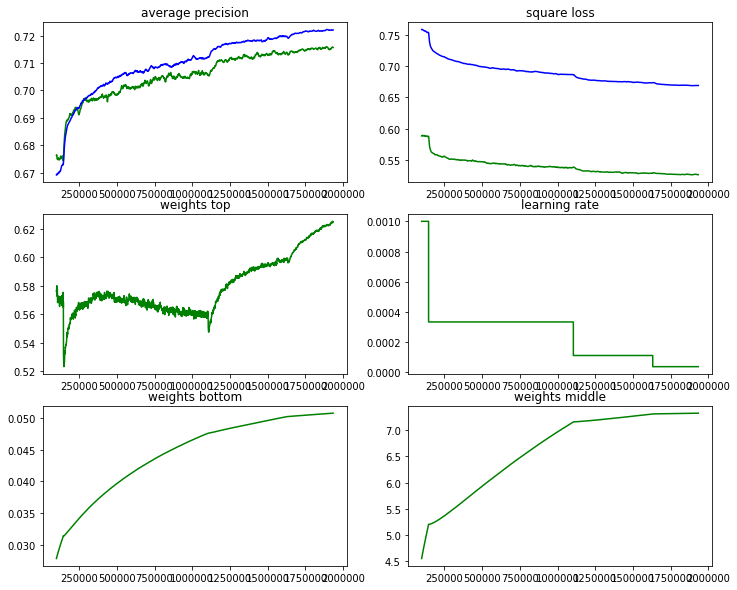

In [57]:
burnin=100
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_test'][2][burnin:],color='g')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_train'][2][burnin:],color='b')
ax2.set_title('square loss')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_test'][2][burnin:],color='g')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_train'][2][burnin:],color='b')
ax3.set_title('weights top')
ax3.plot(model.stats['iter'][2][burnin:],model.stats['nbeta'][2][burnin:],color='g')
ax4.set_title('learning rate')
ax4.plot(model.stats['iter'][2][burnin:],model.stats['lr'][2][burnin:],color='g')
ax5.set_title('weights bottom')
ax5.plot(model.stats['iter'][2][burnin:],model.stats['nw'][2][burnin:],color='g')
ax6.set_title('weights middle')
ax6.plot(model.stats['iter'][2][burnin:],model.stats['nw1'][2][burnin:],color='g')

print max(model.stats['avp_test'][2])
print min(model.stats['mse_test'][2])

# Mirex Stats

In [5]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.707571258428


In [7]:
Accavg = Etotavg = 0
for i in range(3):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/3.,Etotavg/3.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
78.04	72.10	73.73	0.57	0.44	0.11	0.16	0.18
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
47.48	53.70	47.29	0.34	0.76	0.17	0.36	0.24
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
76.77	73.12	69.65	0.55	0.47	0.09	0.21	0.16
0.488029969265 0.557837001257


# Extended test set stats

In [8]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids_ext, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.729065910816


In [9]:
Accavg = Etotavg = 0
for i in range(10):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/10.,Etotavg/10.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
78.04	72.10	73.73	0.57	0.44	0.11	0.16	0.18
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
47.48	53.70	47.29	0.34	0.76	0.17	0.36	0.24
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
76.77	73.12	69.65	0.55	0.47	0.09	0.21	0.16
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
75.06	70.21	72.77	0.56	0.45	0.13	0.14	0.18
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
81.43	71.60	83.32	0.63	0.38	0.12	0.05	0.21
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
78.38	73.72	75.38	0.59	0.40	0.12	0.13	0.15
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
66.69	59.34	72.86	0.49	0.68	0.09	0.18	0.41
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
70.80	68.43	66.73	0.51	0.51	0.13	0.20	0.18
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
73.12	69.84	75.57	0.57	0.45	0.12	0.13	0.21
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
68.97	69.70	62.34	0.49	0.49	0.16	0.22	0.11
0.529693278552 0.503248535322
